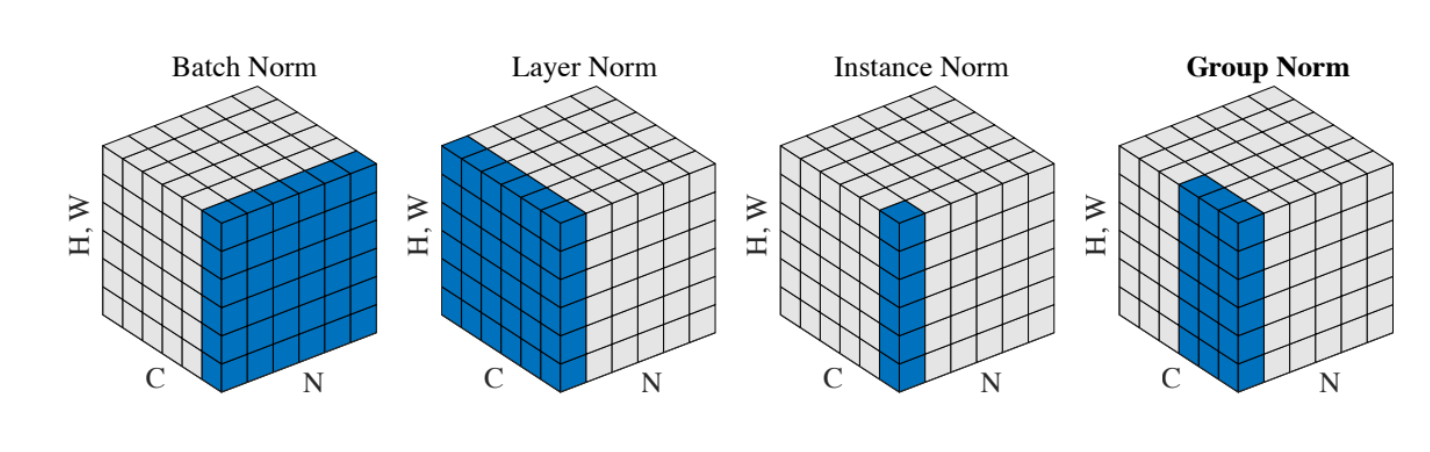

In [4]:
from IPython.display import Image
PATH = "C:/Users/бббюбб/Desktop/batch_norm.PNG"
Image(filename = PATH, width=1000, height=1000)

#### Реализация 1d-нормализации

In [ ]:
import numpy as np
import torch
import torch.nn as nn

def custom_batch_norm1d(input_tensor, eps):
    std = torch.std(input_tensor, dim=0, unbiased=False)
    mean = torch.mean(input_tensor, dim=0)
    normed_tensor = (input_tensor-mean)/(std**2+eps)**0.5
    return normed_tensor


input_tensor = torch.Tensor([[0.0, 0, 1, 0, 2], [0, 1, 1, 0, 10]])
batch_norm = nn.BatchNorm1d(input_tensor.shape[1], affine=False)

# Проверка происходит автоматически вызовом следующего кода
# (раскомментируйте для самостоятельной проверки,
#  в коде для сдачи задания должно быть закомментировано):
import numpy as np
all_correct = True
for eps_power in range(10):
    eps = np.power(10., -eps_power)
    batch_norm.eps = eps
    batch_norm_out = batch_norm(input_tensor)
    custom_batch_norm_out = custom_batch_norm1d(input_tensor, eps)

#### Реализация 1d-нормализации на стадии обучения и на этапе предсказания

In [1]:
import torch
import torch.nn as nn


input_size = 3
batch_size = 5
eps = 1e-1


class CustomBatchNorm1d:
    def __init__(self, weight, bias, eps, momentum):
        self.weight = weight
        self.bias = bias
        self.eps = eps
        self.momentum = momentum
        self.r_mean = torch.zeros(self.bias.shape)
        self.r_var = torch.ones(self.bias.shape)
        self.flag = True

    def __call__(self, input_tensor):
        batch_size = input_tensor.shape[0]
        if self.flag:
            var = torch.var(input_tensor, dim=0, unbiased=False)
            mean = torch.mean(input_tensor, dim=0)
            normed_tensor = (input_tensor-mean)/(var+self.eps)**0.5*self.weight+self.bias
        
            self.r_mean = self.momentum*mean+(1-self.momentum)*self.r_mean
            self.r_var = self.momentum*var*(batch_size/(batch_size-1))+(1-self.momentum)*self.r_var
        else:
            normed_tensor = (input_tensor-self.r_mean)/(self.r_var+self.eps)**0.5*self.weight+self.bias
        return normed_tensor

    def eval(self):
        self.flag = False

batch_norm = nn.BatchNorm1d(input_size, eps=eps)
batch_norm.bias.data = torch.randn(input_size, dtype=torch.float)
batch_norm.weight.data = torch.randn(input_size, dtype=torch.float)
batch_norm.momentum = 0.5

custom_batch_norm1d = CustomBatchNorm1d(batch_norm.weight.data,
                                        batch_norm.bias.data, eps, batch_norm.momentum)

# Проверка происходит автоматически вызовом следующего кода
# (раскомментируйте для самостоятельной проверки,
#  в коде для сдачи задания должно быть закомментировано):
all_correct = True

for i in range(8):
    torch_input = torch.randn(batch_size, input_size, dtype=torch.float)
    norm_output = batch_norm(torch_input)
    custom_output = custom_batch_norm1d(torch_input)
    all_correct &= torch.allclose(norm_output, custom_output) \
        and norm_output.shape == custom_output.shape

batch_norm.eval()
custom_batch_norm1d.eval()

for i in range(8):
    torch_input = torch.randn(batch_size, input_size, dtype=torch.float)
    norm_output = batch_norm(torch_input)
    custom_output = custom_batch_norm1d(torch_input)
    all_correct &= torch.allclose(norm_output, custom_output) \
        and norm_output.shape == custom_output.shape
print(all_correct)

True


#### Реализация 2d-нормализации на стадии обучения

In [3]:
import torch
import torch.nn as nn

eps = 1e-3

input_channels = 3
batch_size = 3
height = 10
width = 10

batch_norm_2d = nn.BatchNorm2d(input_channels, affine=False, eps=eps)

input_tensor = torch.randn(batch_size, input_channels, height, width, dtype=torch.float)


def custom_batch_norm2d(input_tensor, eps):
    var = torch.tensor(input_tensor.numpy().var(axis=(0,2,3)).reshape(1, -1, 1, 1))
    mean = torch.mean(input_tensor, dim=(0,2,3)).reshape(1, -1, 1, 1)
    normed_tensor = (input_tensor-mean)/(var+eps)**0.5
    return normed_tensor


# Проверка происходит автоматически вызовом следующего кода
# (раскомментируйте для самостоятельной проверки,
#  в коде для сдачи задания должно быть закомментировано):
norm_output = batch_norm_2d(input_tensor)
custom_output = custom_batch_norm2d(input_tensor, eps)
print(torch.allclose(norm_output, custom_output) and norm_output.shape == custom_output.shape)

True


#### Нормализация "по каналу" (Layer Norm)

In [13]:
import torch
import torch.nn as nn
import numpy as np

eps = 1e-10


def custom_layer_norm(input_tensor, eps):
    dim_norm = tuple(np.arange(1, len(input_tensor.shape))) # размерность по которым нужно брать среднее и дисперсию
    shape = np.ones(len(input_tensor.shape), dtype=int) # итоговая размерность
    
    var = torch.tensor(input_tensor.numpy().var(axis=dim_norm).reshape((input_tensor.shape[0], *shape[1:])))
    mean = torch.mean(input_tensor, dim=dim_norm).reshape((input_tensor.shape[0], *shape[1:]))
    normed_tensor = (input_tensor-mean)/(var+eps)**0.5
    return normed_tensor


# Проверка происходит автоматически вызовом следующего кода
# (раскомментируйте для самостоятельной проверки,
#  в коде для сдачи задания должно быть закомментировано):
all_correct = True
for dim_count in range(3, 9):
    input_tensor = torch.randn(*list(range(3, dim_count + 2)), dtype=torch.float)
    layer_norm = nn.LayerNorm(input_tensor.size()[1:], elementwise_affine=False, eps=eps)
    norm_output = layer_norm(input_tensor)
    custom_output = custom_layer_norm(input_tensor, eps)

    all_correct &= torch.allclose(norm_output, custom_output, 1e-2)
    all_correct &= norm_output.shape == custom_output.shape
print(all_correct)

True


#### Нормализация "по входу" (Instance Norm)

In [69]:
import torch
import torch.nn as nn

eps = 1e-3

batch_size = 5
input_channels = 2
input_length = 30

instance_norm = nn.InstanceNorm1d(input_channels, affine=False, eps=eps)

input_tensor = torch.randn(batch_size, input_channels, input_length, dtype=torch.float)


def custom_instance_norm1d(input_tensor, eps):
    var = torch.tensor(input_tensor.numpy().var(axis=(2)).reshape(input_tensor.shape[0], input_tensor.shape[1], 1))
    mean = torch.mean(input_tensor, dim=(2)).reshape(input_tensor.shape[0], input_tensor.shape[1], -1)
    normed_tensor = (input_tensor-mean)/(var+eps)**0.5
    return normed_tensor


# Проверка происходит автоматически вызовом следующего кода
# (раскомментируйте для самостоятельной проверки,
#  в коде для сдачи задания должно быть закомментировано):
norm_output = instance_norm(input_tensor)
custom_output = custom_instance_norm1d(input_tensor, eps)
print(torch.allclose(norm_output, custom_output) and norm_output.shape == custom_output.shape)

True


#### Нормализация "по группе" (Group Norm)

In [40]:
import torch
import torch.nn as nn

channel_count = 6
eps = 1e-3
batch_size = 20
input_size = 2

input_tensor = torch.randn(batch_size, channel_count, input_size)


def custom_group_norm(input_tensor, groups, eps):
    grouped_shape = (input_tensor.shape[0], groups, -1)
    grouped = input_tensor.reshape(*grouped_shape)
    var = grouped.var(dim=2, unbiased=False).reshape(*grouped_shape)
    mean = grouped.mean(dim=2).reshape(*grouped_shape)
    normed_tensor = ((grouped - mean) / torch.sqrt(var + eps)).reshape(*input_tensor.shape)
    return normed_tensor


# Проверка происходит автоматически вызовом следующего кода
# (раскомментируйте для самостоятельной проверки,
#  в коде для сдачи задания должно быть закомментировано):
all_correct = True
for groups in [1, 2, 3, 6]:
    group_norm = nn.GroupNorm(groups, channel_count, eps=eps, affine=False)
    norm_output = group_norm(input_tensor)
    custom_output = custom_group_norm(input_tensor, groups, eps)
    all_correct &= torch.allclose(norm_output, custom_output, 1e-3)
    all_correct &= norm_output.shape == custom_output.shape
print(all_correct)

True
